(mlflow-tracker)=
# MLflow tracker

This tutorial demonstrates how to seamlessly integrate and transfer logs from MLflow to MLRun, </br>
creating a unified and powerful platform for your machine learning experiments.

You can combine MLflow and MLRun for a comprehensive solution for managing, tracking, and deploying machine learning models. 

This notebook guides you through the process of:

1. Setting up the integration between MLflow and MLRun.
2. Extracting data, metrics, and artifacts from MLflow experiments.
3. Creating MLRun artifacts and projects to organize and manage the transferred data.
4. Leveraging MLRun's capabilities for model deployment and data processing.

By the end of this tutorial, you will have a understanding of how to establish a smooth flow of data between MLflow and MLRun.

## MLRun installation and configuration
Before running this notebook make sure the mlrun package is installed (pip install mlrun) and that you have configured the access to MLRun service.

In [ ]:
# Install MLRun and scikit-learn if not already installed. Run this only once. Restart the notebook after the install!
%pip install mlrun scikit-learn~=1.4.0 xgboost~=2.0.3

## Create an MLflow Xgboost function

 The `training.py` contains just mlflow code, and does not have any dependence on MLRun.

In [6]:
%%writefile training.py

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow import log_metric
from sklearn import datasets
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

def example_xgb_run():
    # Prepare, train, and test data
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Enable auto logging
    mlflow.xgboost.autolog()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    with mlflow.start_run():
        # Train model
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "learning_rate": 0.3,
            "eval_metric": "mlogloss",
            "colsample_bytree": 1.0,
            "subsample": 1.0,
            "seed": 42,
        }
        model = xgb.train(params, dtrain, evals=[(dtrain, "train")])
        
        # Evaluate model
        y_proba = model.predict(dtest)
        y_pred = y_proba.argmax(axis=1)
        loss = log_loss(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)
        
        # Log metrics by hand
        mlflow.log_metrics({"log_loss": loss, "accuracy": acc})

Overwriting training.py


## Log the data from MLflow in MLRun 

### Change the MLRun configuration to use the tracker

In [3]:
import mlrun

mlrun.mlconf.external_platform_tracking.enabled = True

To run the tracking, set:
`mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime` to True.<br>
This makes the MLRun run-id the same as the MLFlow experiment ID.


### Create the project and function

In [4]:
# Set the tracking
mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime = True

# Create a project for this demo:
project = mlrun.get_or_create_project(name="mlflow-tracking-example", context="./")

# Create a MLRun function using the example train file (all the functions must be located in it):
training_func = project.set_function(
    func="training.py",
    name="example-xgb-run",
    kind="job",
    image="mlrun/mlrun",
)

> 2023-12-06 09:01:32,156 [info] Project loaded successfully: {'project_name': 'mlflow-tracking-example'}
> 2023-12-06 09:01:32,164 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User/mlflow'}


### Run the function

After running the function, you can look at the UI and see that all metrics and parameters are logged in MLRun.

In [7]:
# Run the example code using mlrun
train_run = training_func.run(
    local=True,
    handler="example_xgb_run",
)

> 2023-12-06 09:02:10,520 [info] Storing function: {'name': 'example-xgb-run-example-xgb-run', 'uid': '4185accc906648a9a56f73d97829c1d0', 'db': 'http://mlrun-api:8080'}
> 2023-12-06 09:02:10,626 [warning] `mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime` is set to True but the MLFlow experiment name environment variable ('MLFLOW_EXPERIMENT_NAME') is set for using the name: 'example-xgb-run-example-xgb-run'. This name will be overriden with MLRun's runtime name as set in the MLRun configuration: 'example-xgb-run-example-xgb-run'.
[0]	train-mlogloss:0.74723
[1]	train-mlogloss:0.54060
[2]	train-mlogloss:0.40276
[3]	train-mlogloss:0.30789
[4]	train-mlogloss:0.24051
[5]	train-mlogloss:0.19086
[6]	train-mlogloss:0.15471
[7]	train-mlogloss:0.12807
[8]	train-mlogloss:0.10722
[9]	train-mlogloss:0.09053


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlflow-tracking-example,...7829c1d0,0,Dec 06 09:02:10,completed,example-xgb-run-example-xgb-run,v3io_user=zeevrkind=localowner=zeevrhost=jupyter-zeev-8c4f96bdf-6j652mlflow-user=iguaziomlflow-run-name=adaptable-perch-39mlflow-run-id=3290451d92f24ea5988f8debd9d51670mlflow-experiment-id=175092470379844344,,colsample_bytree=1.0custom_metric=Noneearly_stopping_rounds=Noneeval_metric=mloglosslearning_rate=0.3maximize=Nonenum_boost_round=10num_class=3objective=multi:softprobseed=42subsample=1.0verbose_eval=True,accuracy=1.0log_loss=0.06621863381213823train-mlogloss=0.09053360810503364,feature_importance_weight_jsonfeature_importance_weight_pngmodel


> 2023-12-06 09:02:19,281 [info] Run execution finished: {'status': 'completed', 'name': 'example-xgb-run-example-xgb-run'}


### Examine the results


In [5]:
train_run.outputs

{'accuracy': 1.0,
 'log_loss': 0.06621863381213823,
 'train-mlogloss': 0.09053360810503364,
 'feature_importance_weight_json': 'store://artifacts/mlflow-tracking-example/example-xgb-run-example-xgb-run_feature_importance_weight_json:ad1fec0b0df04083b034e3839460b623',
 'feature_importance_weight_png': 'store://artifacts/mlflow-tracking-example/example-xgb-run-example-xgb-run_feature_importance_weight_png:ad1fec0b0df04083b034e3839460b623',
 'model': 'store://artifacts/mlflow-tracking-example/example-xgb-run-example-xgb-run_model:ad1fec0b0df04083b034e3839460b623'}

In [6]:
train_run.status.results

{'accuracy': 1.0,
 'log_loss': 0.06621863381213823,
 'train-mlogloss': 0.09053360810503364}

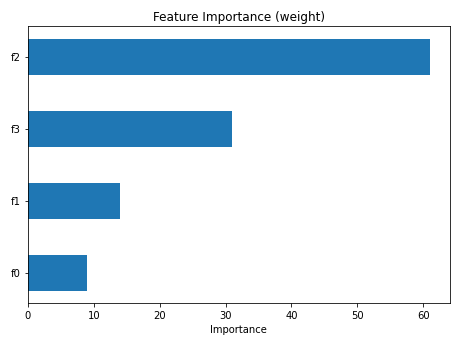

In [7]:
train_run.artifact("feature_importance_weight_png").show()

### You can also examine the results using the UI

Look at collected artifacts: 

<img src="./_static/images/mlflow-artifacts.png" width="1200" >


And at results:

<img src="./_static/images/mlflow-results.png" width="1200" >

## Use the function for model serving

### Implement the load and predict functions

In [8]:
%%writefile serving.py

import zipfile
from typing import Any, Dict, List, Union

import mlflow
import numpy as np
import os
import mlrun
from mlrun.serving.v2_serving import V2ModelServer
import xgboost as xgb
import pandas as pd

class MLFlowModelServer(V2ModelServer):
    """
    The MLFlow tracker Model serving class  inherits the V2ModelServer class, resulting in automatic 
    initialization by the model server. It can run locally as part of a nuclio serverless function,
    or as part of a real-time pipeline.
    """

    def load(self):
        """
        loads a model that was logged by the MLFlow tracker model
        """
        # Unzip the model dir and then use mlflow's load function
        model_file, _ = self.get_model(".zip")
        model_path_unzip = model_file.replace(".zip", "")

        with zipfile.ZipFile(model_file, "r") as zip_ref:
            zip_ref.extractall(model_path_unzip)
            
        self.model = mlflow.pyfunc.load_model(model_path_unzip)

    def predict(self, request: Dict[str, Any]) -> list:
        """
        Infer the inputs through the model. The inferred data
        is read from the "inputs" key of the request.

        :param request: The request to the model using xgboost's predict. 
                The input to the model is read from the "inputs" key.

        :return: The model's prediction on the given input.
        """
        
        # Get the inputs and set to accepted type:
        inputs = pd.DataFrame(request["inputs"])

        # Predict using the model's predict function:
        predictions = self.model.predict(inputs)

        # Return as list:
        return predictions.tolist()


Overwriting serving.py


### Create the server and serving function

In [9]:
serving_func = project.set_function(
    func="serving.py",
    name="example-xgb-server",
    kind="serving",
    image="mlrun/mlrun",
)

> 2023-11-07 13:21:19,690 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User'}


In [10]:
# Add the model
serving_func.add_model(
    "mlflow_xgb_model",
    class_name="MLFlowModelServer",
    model_path=train_run.outputs["model"],
)

In [11]:
# Create a mock server
server = serving_func.to_mock_server()

> 2023-11-07 13:21:19,833 [info] model mlflow_xgb_model was loaded
> 2023-11-07 13:21:19,834 [info] Loaded ['mlflow_xgb_model']


### Test the model 

In [12]:
# An example taken randomly from the dataset that the model was trained on, each
x = [[5.1, 3.5, 1.4, 0.2]]
result = server.test("/v2/models/mlflow_xgb_model/predict", {"inputs": x})

In [13]:
# Look at the result, it shows the probability of the given example to be each of the
# irises featured in the dataset
result

{'id': '4188f3585d9d42b7b184324f713c9c26',
 'model_name': 'mlflow_xgb_model',
 'outputs': [[0.9505813121795654, 0.025876399129629135, 0.02354232780635357]]}